In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy

from sklearn.metrics import accuracy_score, mean_absolute_error
from functools import partial

from treeck import SplitTree
from treeck.xgb import addtree_from_xgb_model
from treeck.verifier import Verifier
from treeck.distributed import DistributedVerifier
from treeck.z3backend import Z3Backend as Backend
import z3

from dask.distributed import Client

In [3]:
mat = scipy.io.loadmat("../data/mnist.mat")
X = mat["X"]
y = mat["y"].reshape((70000,))

num_examples = X.shape[0]
num_features = X.shape[1]

np.random.seed(111)
indices = np.random.permutation(num_examples)

m = int(num_examples*0.9)
Itrain = indices[0:m]
Itest = indices[m:]

In [4]:
label = y==5
dtrain = xgb.DMatrix(X[Itrain], label[Itrain], missing=0)
dtest = xgb.DMatrix(X[Itest], label[Itest], missing=0)

params = {
    "objective": "binary:logistic",
    "tree_method": "exact",
    "max_depth": 6,
    "learning_rate": 0.25,
    "eval_metric": "error"
}
#xgb.cv(params, dtrain,
#      num_boost_round = 10,
#      nfold=5, metrics={'error'}, seed=0,
#      callbacks=[xgb.callback.print_evaluation(show_stdv=True),
#                 xgb.callback.early_stop(3)])
model = xgb.train(params, dtrain, num_boost_round=200,
                  early_stopping_rounds=5,
                  evals=[(dtrain, "train"), (dtest, "test")])

[0]	train-error:0.04846	test-error:0.047
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 5 rounds.
[1]	train-error:0.033333	test-error:0.034571
[2]	train-error:0.03081	test-error:0.031857
[3]	train-error:0.029635	test-error:0.032857
[4]	train-error:0.027714	test-error:0.029286
[5]	train-error:0.023889	test-error:0.027143
[6]	train-error:0.02146	test-error:0.025286
[7]	train-error:0.018968	test-error:0.021429
[8]	train-error:0.017127	test-error:0.020714
[9]	train-error:0.015587	test-error:0.018429
[10]	train-error:0.014111	test-error:0.017143
[11]	train-error:0.01354	test-error:0.015857
[12]	train-error:0.012444	test-error:0.015857
[13]	train-error:0.011254	test-error:0.015
[14]	train-error:0.010222	test-error:0.014571
[15]	train-error:0.009206	test-error:0.014143
[16]	train-error:0.00881	test-error:0.013571
[17]	train-error:0.008016	test-error:0.012857
[18]	train-error:0.007143	test-error:0.012
[19]	t

In [5]:
at = addtree_from_xgb_model(num_features, model)
at.base_score = 0.0
pred = model.predict(xgb.DMatrix(X), output_margin=True)
acc = accuracy_score(pred > 0.0, label)
print(f"accuracy: {acc}")
mae = mean_absolute_error(pred[:10000], at.predict(X[:10000]))
print(f"mae model difference {mae}")

accuracy: 0.9859
mae model difference 5.360151079890451e-07


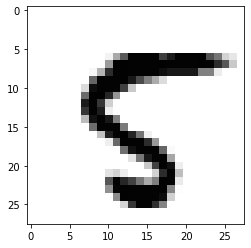

In [6]:
indices = np.random.permutation(num_examples)
instance_index = indices[np.argmax((y[indices] == 5))]
instance = X[instance_index, :]

fig, ax = plt.subplots()
ax.imshow(255-instance.reshape((28,28)), cmap='gray')
plt.show()

In [7]:
def vfactory(instance, num_features, at, leaf):
    offset = 10
    max_sum_offset = 50
    v = Verifier(at, leaf, Backend())
    
    sum_constraint = 0
    for j, pixel in zip(range(num_features), instance):
        x = v.xvar(j)
        v.add_constraint((x > max(0, pixel-offset)) & (x < min(255, pixel+offset)))
        sum_constraint += z3.If(x.get()-pixel <= 0, pixel-x.get(), x.get()-pixel)
    v.add_constraint(sum_constraint < max_sum_offset)
    v.add_constraint(v.fvar() < 0.0)
    return v

vfac = partial(vfactory, instance, num_features)

with Client("tcp://localhost:30333") as client:
    client.restart()
    st = SplitTree(at, {})
    dv = DistributedVerifier(client, st, vfac,
            check_paths = True,
            saturate_workers_factor=2,
            stop_when_sat = False)

    dv.check()

Result.SAT for 11 in 0.1390049839992571s!
Result.SAT for 14 in 0.5380584429985902s!
Result.SAT for 12 in 0.7346577030002663s!
Result.UNSAT for 10 in 0.007487430000765016s!
Result.SAT for 13 in 2.0818180369988113s!
Result.SAT for 8 in 0.46793951700055914s!
Result.UNSAT for 9 in 0.006138844999441062s!
Result.SAT for 7 in 1.7806317069989746s!


check_paths_time 37.75940841100055
7, Result.SAT, 1.7806
 328: [4.5, inf)   208: [-inf, 252)  355: [-inf, 510) 


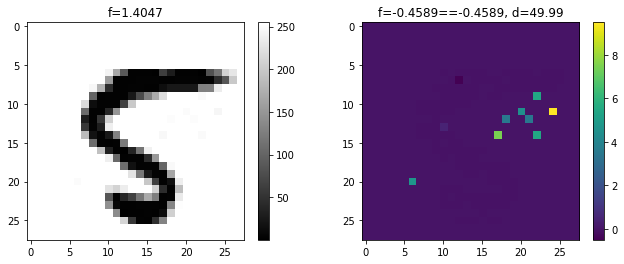

8, Result.SAT, 0.4679
 328: [4.5, inf)   208: [252, inf)   355: [-inf, 510) 


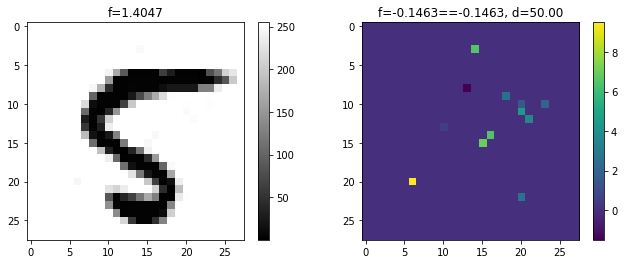

9, Result.UNSAT, 0.0061
 328: [4.5, inf)   208: [-inf, 252)  355: [510, inf)  
10, Result.UNSAT, 0.0075
 328: [4.5, inf)   208: [252, inf)   355: [510, inf)  
11, Result.SAT, 0.1390
 209: [-inf, 250)  328: [-inf, 4.5)  208: [-inf, 252) 


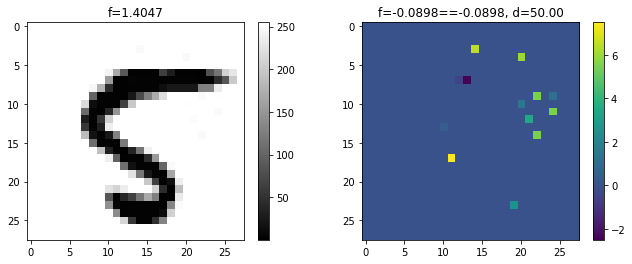

12, Result.SAT, 0.7347
 209: [250, inf)   328: [-inf, 4.5)  208: [-inf, 252) 


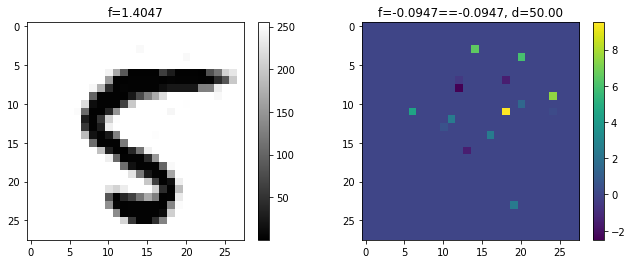

13, Result.SAT, 2.0818
 209: [-inf, 250)  328: [-inf, 4.5)  208: [252, inf)  


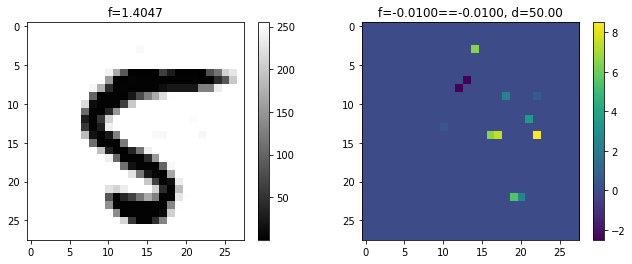

14, Result.SAT, 0.5381
 209: [250, inf)   328: [-inf, 4.5)  208: [252, inf)  


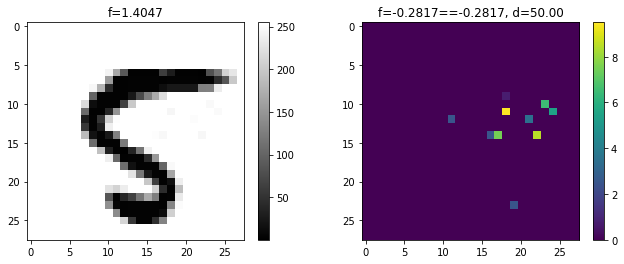

In [8]:
for domtree_node_id, res in dv.results.items():
    status = res.get("status", None)
    if "check_paths_time" in res:
        print("check_paths_time", res["check_paths_time"])
    if status is not None:
        print(f"{domtree_node_id}, {status}, {res.get('check_time', ''):.4f}")
        for fid, doms in dv._st.get_leaf_domains(domtree_node_id).items():
            print(f" {fid:3}: {str(doms):12}", end="")
        print()
    
    if status is not None and status.is_sat():
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,4))
        inst = np.array(res["model"]["xs"])
        d = sum(abs(inst-instance))
        im0 = ax0.imshow(255-inst.reshape((28,28)), cmap='gray')
        im1 = ax1.imshow(inst.reshape((28,28))-instance.reshape((28,28)))
        fig.colorbar(im0, ax=ax0)
        fig.colorbar(im1, ax=ax1)
        ax0.set_title(f"f={at.predict_single(instance):.4f}")
        ax1.set_title(f"f={res['model']['f']:.4f}=={at.predict_single(inst):.4f}, d={d:.2f}")
        plt.show()